# Music Genre Classification using Keras

---


#### Group Members ICS 4A

*   111755 - Fenny Otieno
*   111053 - Tonui Mitchell
*   111530 - Esther Ndegwa
*   110503 - Nasha Ayiera



## Dataset


---

This dataset was obtained from Kaggle.

It contains:


*   genres original folder :  contains the 10 genres each with 100 audio files
*   images original folder : contains the visual representation of each video file
*   2 csv files : contains the features of the audio files. The csv files will later be generated.

For this project, we used the genres original folder and the csv file to classify the music genres.



Link to dataset: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification 

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
pip install librosa

Importing necessary libraries

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display # used for music and audio analysis

import csv
import pandas as pd
import os

import IPython

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from keras import models, layers, Sequential

import random


Select an example file and display its features

In [115]:
example_file = "/content/drive/MyDrive/MusicGenres/genres_original/pop/pop.00020.wav"

In [116]:
#load the audio as a waveform and store the sampling rate
waveform_y, sampling_rate = librosa.load (example_file)

In [117]:
IPython.display.Audio(example_file, rate=sampling_rate)

In [118]:
#run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=waveform_y, sr=sampling_rate)


In [119]:
print(waveform_y)

[-0.1812439  -0.11434937 -0.12710571 ... -0.10079956 -0.07598877
 -0.06747437]


In [120]:
print(sampling_rate)

22050


Displaying the audio as an image

The audio is first displayed as a waveform, identifying its amplitude over time.

In [121]:
FIG_SIZE = (16,8) 

Text(0.5, 1.0, 'Waveform')

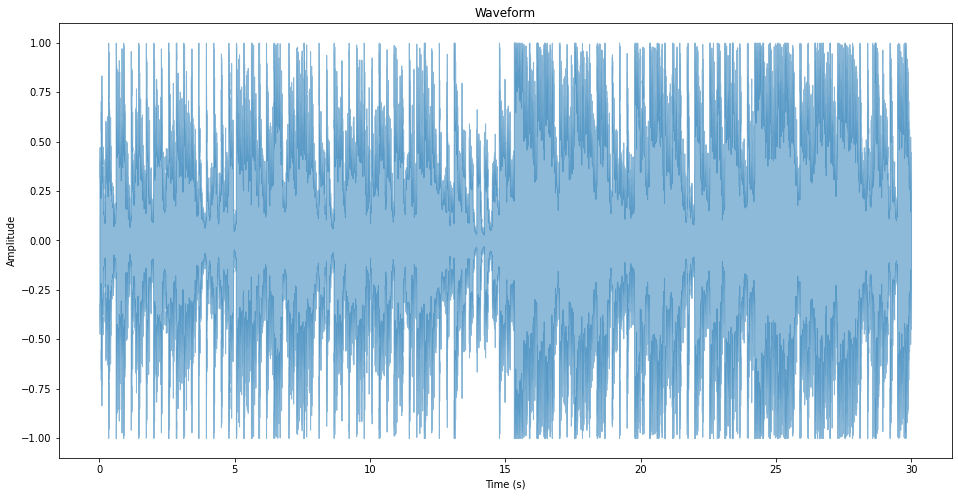

In [122]:
#display the waveform of the audio
plt.figure (figsize=FIG_SIZE)
librosa.display.waveshow(waveform_y, sampling_rate, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Fast Fourier Transform (FFT) is a digital representation of the audio. displays it in terms of magnitude and frequency

It gives an overview of the audio file but does not give as many details.

In [123]:
#Fourier Transform 
fft = np.fft.fft(waveform_y)

In [124]:
spectrum = np.abs(fft)
frequency = np.linspace(0, sampling_rate, len(spectrum))

Power spectrum of a time series describes the distribution of power into frequency components composing that signal. 

According to Fourier analysis, any physical signal can be decomposed into a number of discrete frequencies, or a spectrum of frequencies over a continuous range.

Text(0.5, 1.0, 'Power Spectrum')

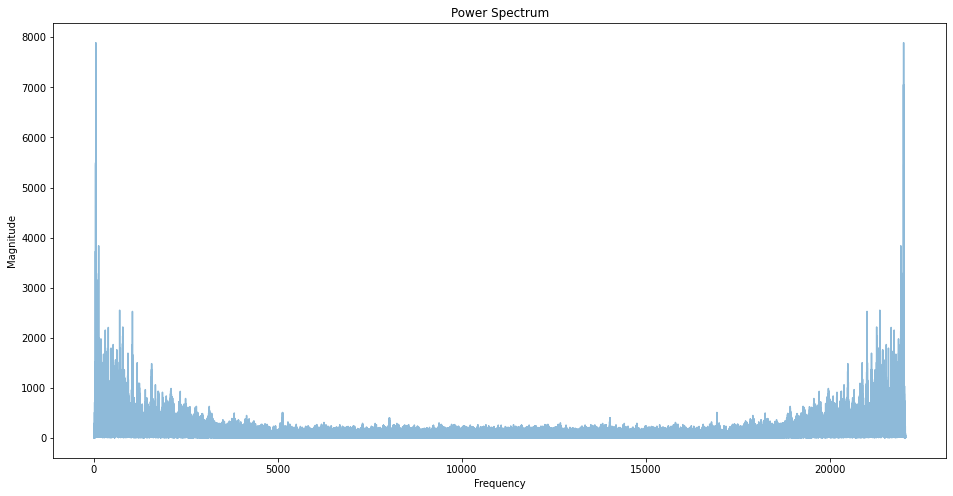

In [125]:
# Power Spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(frequency, spectrum, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum")

The Short-time Fourier transform (STFT), is a Fourier-related transform used to determine the  frequency and phase content of local sections of a signal as it changes over time.

It differs from FFT such that it focuses on a shorter time frames and is therefore more accurate.

In [126]:
# Spectrogram (STFT)
hop_length = 512 # num. of samples
n_fft = 2048 # num. of samples for window

In [127]:
# Perform STFT
stft = librosa.stft(waveform_y, n_fft=n_fft, hop_length=hop_length)

In [128]:
# 
D = librosa.stft(waveform_y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

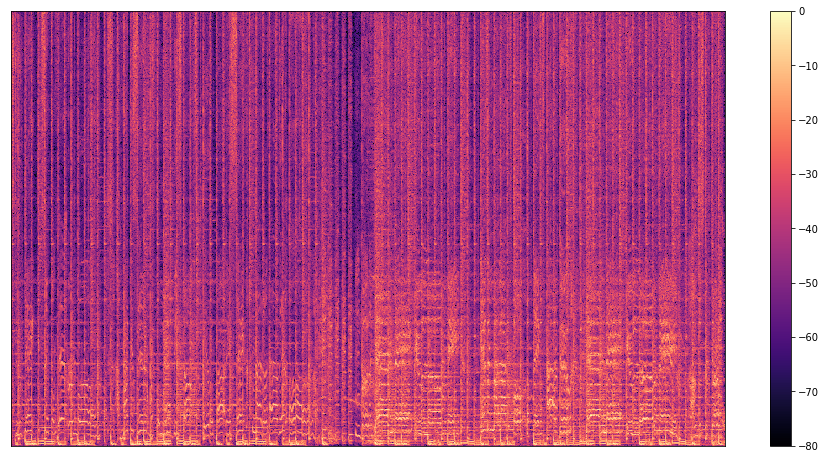

In [129]:
#display the spectogram of the audio
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(S_db)
plt.colorbar()


Mel-frequency cepstrum (MFCC) is a scale that relates the perceived frequency of a tone to the actual measured frequency. 

It scales the frequency in an attempt to match more closely what the human ear can hear because humans are better at identifying small changes in speech especially at lower frequencies.

In [130]:
# MFCCs (we use 13 MFCCs)
MFCCs = librosa.feature.mfcc(waveform_y, sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

Text(0.5, 1.0, 'MFCCs')

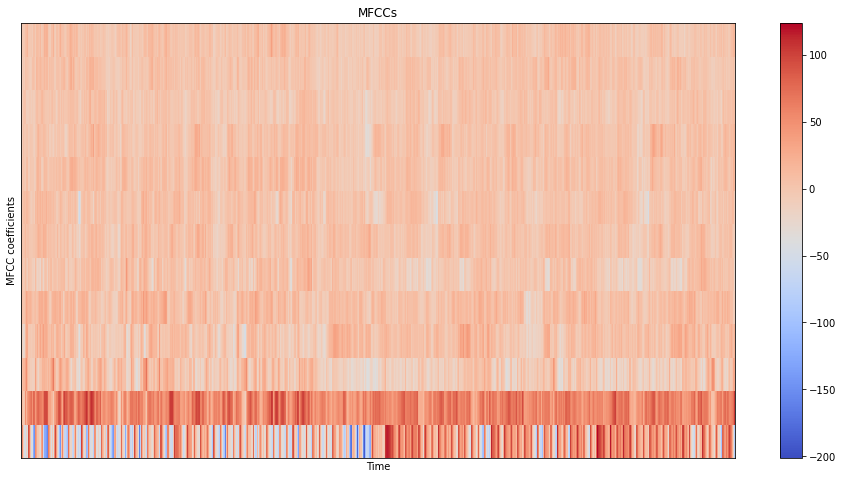

In [131]:
# Plot MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sampling_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

## Extraction of features from the sample audios

---

Features of the audios are extracted and inserted into the csv file 

In [132]:
#create the headers for the dataset
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range (1, 21):
  header += f' mfcc{i}'

header += ' label'
header = header.split()

In [133]:
header

['filename',
 'chroma_stft',
 'rmse',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20',
 'label']

In [134]:
%cd /content/drive/MyDrive/MusicGenres/

/content/drive/My Drive/MusicGenres


In [135]:
#create the csv file and insert the features
file = open('music_genre.csv', 'w', newline='')
with file:
  writer = csv.writer(file)
  writer.writerow(header)

pd.DataFrame(pd.read_csv('music_genre.csv'))

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label


In [136]:
%ls -lrt

total 12412
-rw-------  1 root root 11075018 Mar 24  2020 features_3_sec.csv
-rw-------  1 root root  1108271 Mar 24  2020 features_30_sec.csv
drwx------  2 root root     4096 Aug 14 07:47 images_original/
drwx------ 12 root root     4096 Aug 14 07:47 genres_original/
-rw-------  1 root root   516759 Aug 18 17:33 music_genre2.csv
-rw-------  1 root root      228 Aug 27 20:45 music_genre.csv


In [137]:
%cd /content/drive/My Drive/MusicGenres/genres_original
%ls -lrt

/content/drive/My Drive/MusicGenres/genres_original
total 40
drwx------ 2 root root 4096 Aug 14 07:47 rock/
drwx------ 2 root root 4096 Aug 14 07:47 reggae/
drwx------ 2 root root 4096 Aug 14 07:47 metal/
drwx------ 2 root root 4096 Aug 14 07:47 jazz/
drwx------ 2 root root 4096 Aug 14 07:47 hiphop/
drwx------ 2 root root 4096 Aug 14 07:47 disco/
drwx------ 2 root root 4096 Aug 14 07:47 country/
drwx------ 2 root root 4096 Aug 14 07:47 classical/
drwx------ 2 root root 4096 Aug 14 07:47 blues/
drwx------ 2 root root 4096 Aug 14 07:47 pop/


In [138]:
%cd /content/drive/My Drive/MusicGenres


/content/drive/My Drive/MusicGenres


In [139]:
#Extract the features using the librosa library 
genres = 'rock reggae metal jazz hiphop disco country classical blues pop'.split()
count = 0

#loop through the audio files in the genre files
for genre in genres:
  for filename in os.listdir(f'/content/drive/My Drive/MusicGenres/genres_original/{genre}'):
    songname = f'/content/drive/My Drive/MusicGenres/genres_original/{genre}/{filename}'

    #loading a sample of the output
    waveform_y, sampling_rate = librosa.load (songname, duration=20)

    #extract the features
    chroma_stft = librosa.feature.chroma_stft(y=waveform_y, sr=sampling_rate)
    rmse = librosa.feature.rms(y=waveform_y)
    spectral_centroid = librosa.feature.spectral_centroid(y=waveform_y, sr=sampling_rate)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform_y, sr=sampling_rate)
    rolloff = librosa.feature.spectral_rolloff (y=waveform_y, sr=sampling_rate)
    zero_crossing_rate = librosa.feature.zero_crossing_rate (waveform_y)
    mfcc = librosa.feature.mfcc (y=waveform_y, sr=sampling_rate)


    #preparing an input row for csv
    to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spectral_centroid)} {np.mean(spectral_bandwidth)} {np.mean(rolloff)} {np.mean(zero_crossing_rate)}'
    for e in mfcc:
      to_append += f' {np.mean(e)}'
    to_append += f' {genre}'

    count +=1
    print(f' {count} - {to_append}')

    #writing into csv
    file = open('music_genre.csv', 'a', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(to_append.split())

## Preparing the dataset

---
Cleaning, encoding and standardizing of the data set in preparation for training.


In [140]:
music_data = pd.read_csv('/content/drive/MyDrive/MusicGenres/music_genre.csv')


In [141]:
music_data.head(5)

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,rock.00006.wav,0.349636,0.170328,1680.526356,1634.842283,3238.523805,0.087021,-107.362511,136.211502,-47.741806,50.068577,-12.821674,10.702412,-13.791328,15.012980,-11.882832,2.586876,-12.506304,1.826185,-12.043388,-0.557148,-0.704891,-5.910402,-8.230802,-2.344419,-1.583620,-3.442256,rock
1,rock.00007.wav,0.359514,0.157120,1218.809256,1707.581498,2565.486304,0.041990,-146.549179,150.257645,-8.511383,39.776062,2.457289,20.059875,-12.434711,16.524233,-11.555931,8.501875,-9.588740,3.707215,-8.176876,2.428884,-6.164787,-2.618794,-6.396785,-5.510914,-2.384279,-2.118835,rock
2,rock.00002.wav,0.436542,0.147860,1869.238294,1968.281627,3897.797042,0.077229,-121.932350,117.864502,-28.879341,42.100788,-6.498641,22.070221,-12.230353,17.268192,-9.871669,11.831244,-6.254823,13.952238,-2.631247,5.946499,-2.459702,5.167741,-2.708923,0.892556,-1.605619,-0.537618,rock
3,rock.00003.wav,0.372871,0.154285,1454.659752,1905.509006,3106.127080,0.045176,-147.604950,129.970276,-4.043167,36.695839,-1.650929,32.714920,-0.294163,19.678555,-12.714108,13.117222,-3.614977,11.701581,-4.081814,6.798007,-1.359581,3.284381,-2.963130,-0.598956,-1.108383,0.300122,rock
4,rock.00005.wav,0.353030,0.200379,1598.829764,1659.618440,3013.224548,0.078429,-63.413960,147.089722,-53.769333,30.363989,-9.031729,20.190878,-25.266369,18.650560,-15.092291,4.847668,-8.708841,5.650019,-3.665713,3.751522,-5.750141,-2.627757,-1.857472,-7.171092,-5.338895,-7.540329,rock


In [142]:
music_data.shape

(999, 28)

In [143]:
music_data.isnull().sum()

filename              0
chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
label                 0
dtype: int64

In [144]:
music_data.drop('filename', inplace=True, axis=1)

In [145]:
music_data.shape

(999, 27)

In [146]:
music_data.head(5)

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.349636,0.170328,1680.526356,1634.842283,3238.523805,0.087021,-107.362511,136.211502,-47.741806,50.068577,-12.821674,10.702412,-13.791328,15.012980,-11.882832,2.586876,-12.506304,1.826185,-12.043388,-0.557148,-0.704891,-5.910402,-8.230802,-2.344419,-1.583620,-3.442256,rock
1,0.359514,0.157120,1218.809256,1707.581498,2565.486304,0.041990,-146.549179,150.257645,-8.511383,39.776062,2.457289,20.059875,-12.434711,16.524233,-11.555931,8.501875,-9.588740,3.707215,-8.176876,2.428884,-6.164787,-2.618794,-6.396785,-5.510914,-2.384279,-2.118835,rock
2,0.436542,0.147860,1869.238294,1968.281627,3897.797042,0.077229,-121.932350,117.864502,-28.879341,42.100788,-6.498641,22.070221,-12.230353,17.268192,-9.871669,11.831244,-6.254823,13.952238,-2.631247,5.946499,-2.459702,5.167741,-2.708923,0.892556,-1.605619,-0.537618,rock
3,0.372871,0.154285,1454.659752,1905.509006,3106.127080,0.045176,-147.604950,129.970276,-4.043167,36.695839,-1.650929,32.714920,-0.294163,19.678555,-12.714108,13.117222,-3.614977,11.701581,-4.081814,6.798007,-1.359581,3.284381,-2.963130,-0.598956,-1.108383,0.300122,rock
4,0.353030,0.200379,1598.829764,1659.618440,3013.224548,0.078429,-63.413960,147.089722,-53.769333,30.363989,-9.031729,20.190878,-25.266369,18.650560,-15.092291,4.847668,-8.708841,5.650019,-3.665713,3.751522,-5.750141,-2.627757,-1.857472,-7.171092,-5.338895,-7.540329,rock


In [147]:
original_features = list(music_data.columns)
len(original_features)

27

ENCODE THE DATASET

In [148]:
categorical_features = list(music_data.select_dtypes(include=['object']).columns)
categorical_features

['label']

In [149]:
numerical = list(set(original_features)-set(categorical_features))
numerical

['mfcc12',
 'zero_crossing_rate',
 'mfcc6',
 'rolloff',
 'mfcc15',
 'mfcc17',
 'mfcc13',
 'mfcc5',
 'mfcc8',
 'mfcc2',
 'mfcc18',
 'mfcc1',
 'mfcc3',
 'rmse',
 'mfcc16',
 'mfcc10',
 'mfcc4',
 'mfcc11',
 'mfcc19',
 'spectral_bandwidth',
 'mfcc9',
 'spectral_centroid',
 'mfcc7',
 'chroma_stft',
 'mfcc14',
 'mfcc20']

In [150]:
target=['label']

In [151]:
# ordinal = list(set(categorical_features))

In [152]:
# for feature in ordinal:
#   music_data[feature] = music_data[feature].astype('category').cat.codes

# df_ordinal = music_data[ordinal]

In [153]:
# music_data[categorical_features]

In [154]:
#LabelEncoder() 
target = music_data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(target)
print(y)

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [155]:
music_data[numerical]

,mfcc12,zero_crossing_rate,mfcc6,rolloff,mfcc15,mfcc17,mfcc13,mfcc5,mfcc8,mfcc2,mfcc18,mfcc1,mfcc3,rmse,mfcc16,mfcc10,mfcc4,mfcc11,mfcc19,spectral_bandwidth,mfcc9,spectral_centroid,mfcc7,chroma_stft,mfcc14,mfcc20
0,1.826185,0.087021,10.702412,3238.523805,-0.704891,-8.230802,-12.043388,-12.821674,15.012980,136.211502,-2.344419,-107.362511,-47.741806,0.170328,-5.910402,2.586876,50.068577,-12.506304,-1.583620,1634.842283,-11.882832,1680.526356,-13.791328,0.349636,-0.557148,-3.442256
1,3.707215,0.041990,20.059875,2565.486304,-6.164787,-6.396785,-8.176876,2.457289,16.524233,150.257645,-5.510914,-146.549179,-8.511383,0.157120,-2.618794,8.501875,39.776062,-9.588740,-2.384279,1707.581498,-11.555931,1218.809256,-12.434711,0.359514,2.428884,-2.118835
2,13.952238,0.077229,22.070221,3897.797042,-2.459702,-2.708923,-2.631247,-6.498641,17.268192,117.864502,0.892556,-121.932350,-28.879341,0.147860,5.167741,11.831244,42.100788,-6.254823,-1.605619,1968.281627,-9.871669,1869.238294,-12.230353,0.436542,5.946499,-0.537618
3,11.701581,0.045176,32.714920,3106.127080,-1.359581,-2.963130,-4.081814,-1.650929,19.678555,129.970276,-0.598956,-147.604950,-4.043167,0.154285,3.284381,13.117222,36.695839,-3.614977,-1.108383,1905.509006,-12.714108,1454.659752,-0.294163,0.372871,6.798007,0.300122
4,5.650019,0.078429,20.190878,3013.224548,-5.750141,-1.857472,-3.665713,-9.031729,18.650560,147.089722,-7.171092,-63.413960,-53.769333,0.200379,-2.627757,4.847668,30.363989,-8.708841,-5.338895,1659.618440,-15.092291,1598.829764,-25.266369,0.353030,3.751522,-7.540329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,6.721454,0.154622,9.416309,7376.683352,-3.085043,-0.755823,3.361121,7.157108,4.503986,54.779957,1.426481,-22.371708,12.966942,0.220221,1.981310,2.890036,16.431017,-0.610082,1.801505,3142.855565,7.804162,3486.208821,1.848299,0.481231,-0.771428,3.559129
995,-4.320454,0.128865,13.922048,7444.055799,-1.923334,-4.338674,-4.671074,10.554246,4.093385,56.566116,1.839703,-20.999525,19.826117,0.245928,-1.026926,2.109603,20.354937,-5.507509,0.045393,3197.297008,0.647661,3305.929432,1.855747,0.422273,-0.346300,-1.477863
996,-3.197931,0.108836,2.558056,7321.139179,-7.896334,-5.820321,-5.074272,10.439270,-1.297925,70.395844,-1.689027,-48.133846,44.110535,0.289746,-7.110096,3.495735,23.202387,-5.212837,1.411201,3296.908670,6.905687,3093.029666,11.274704,0.375842,-8.551385,-2.532226
997,-1.913640,0.105813,7.150047,7226.625404,0.635815,3.401087,-6.171422,14.945088,10.307749,55.465088,0.579452,-62.664951,30.490837,0.246188,4.630245,4.347775,27.665348,1.497907,5.015378,3248.420923,14.883007,3251.614104,14.242846,0.355888,0.652630,2.440439


In [156]:
new_music_data = pd.concat([df_ordinal, music_data[numerical]], axis=1)

In [157]:
new_music_data.shape

(999, 27)

In [158]:
new_music_data.head(10)

,label,mfcc12,zero_crossing_rate,mfcc6,rolloff,mfcc15,mfcc17,mfcc13,mfcc5,mfcc8,mfcc2,mfcc18,mfcc1,mfcc3,rmse,mfcc16,mfcc10,mfcc4,mfcc11,mfcc19,spectral_bandwidth,mfcc9,spectral_centroid,mfcc7,chroma_stft,mfcc14,mfcc20
0,9,1.826185,0.087021,10.702412,3238.523805,-0.704891,-8.230802,-12.043388,-12.821674,15.012980,136.211502,-2.344419,-107.362511,-47.741806,0.170328,-5.910402,2.586876,50.068577,-12.506304,-1.583620,1634.842283,-11.882832,1680.526356,-13.791328,0.349636,-0.557148,-3.442256
1,9,3.707215,0.041990,20.059875,2565.486304,-6.164787,-6.396785,-8.176876,2.457289,16.524233,150.257645,-5.510914,-146.549179,-8.511383,0.157120,-2.618794,8.501875,39.776062,-9.588740,-2.384279,1707.581498,-11.555931,1218.809256,-12.434711,0.359514,2.428884,-2.118835
2,9,13.952238,0.077229,22.070221,3897.797042,-2.459702,-2.708923,-2.631247,-6.498641,17.268192,117.864502,0.892556,-121.932350,-28.879341,0.147860,5.167741,11.831244,42.100788,-6.254823,-1.605619,1968.281627,-9.871669,1869.238294,-12.230353,0.436542,5.946499,-0.537618
3,9,11.701581,0.045176,32.714920,3106.127080,-1.359581,-2.963130,-4.081814,-1.650929,19.678555,129.970276,-0.598956,-147.604950,-4.043167,0.154285,3.284381,13.117222,36.695839,-3.614977,-1.108383,1905.509006,-12.714108,1454.659752,-0.294163,0.372871,6.798007,0.300122
4,9,5.650019,0.078429,20.190878,3013.224548,-5.750141,-1.857472,-3.665713,-9.031729,18.650560,147.089722,-7.171092,-63.413960,-53.769333,0.200379,-2.627757,4.847668,30.363989,-8.708841,-5.338895,1659.618440,-15.092291,1598.829764,-25.266369,0.353030,3.751522,-7.540329
5,9,8.989614,0.090098,23.734035,4309.088715,-8.434274,-8.393640,-12.127604,-13.868319,15.469020,110.858719,0.930442,-89.217369,-22.352005,0.152300,5.195293,13.677023,42.036900,-11.887721,-2.796263,2125.127666,-16.635342,2020.127542,-14.695402,0.409100,3.149293,1.138630
6,9,12.982270,0.038875,37.912315,2940.206506,-5.083183,-5.131258,-8.367615,0.284186,16.125740,131.529251,0.080974,-140.110092,6.670040,0.197041,1.489780,6.366815,55.513161,-5.787141,-4.790070,1865.541086,-8.574000,1340.342700,-10.322685,0.377574,1.444459,-4.670991
7,9,12.042076,0.051902,30.321156,2929.602277,-4.643397,-5.169280,-3.642042,-4.715849,14.803811,144.258896,-2.401708,-89.982941,-28.944351,0.209723,3.953996,8.748413,43.354870,-4.166637,-0.123720,1722.442433,-12.247801,1404.502543,-6.047913,0.399428,3.653238,-4.669383
8,9,10.271178,0.133986,25.008305,4488.423826,-10.424129,-8.366231,-14.352055,-17.238617,19.692879,106.768456,3.018160,-54.794312,-42.325779,0.155847,2.648075,17.104851,52.442638,-15.055392,-3.958245,2062.843985,-18.420240,2254.742408,-17.918932,0.397825,1.484162,-0.583955
9,9,6.642861,0.122595,20.484484,4411.396411,-10.426284,-9.082682,-10.947404,-22.242414,14.992768,113.492966,-0.235789,-50.742096,-32.716068,0.160195,3.899093,18.254049,38.810108,-17.387268,-2.109144,2105.145495,-23.974726,2217.057138,-19.252302,0.398447,0.835151,-1.129750


STANDARDIZING THE DATASET

In [159]:
X = new_music_data.to_numpy()

In [160]:
X[0]

array([ 9.00000000e+00,  1.82618546e+00,  8.70211218e-02,  1.07024117e+01,
        3.23852380e+03, -7.04891026e-01, -8.23080158e+00, -1.20433884e+01,
       -1.28216743e+01,  1.50129805e+01,  1.36211502e+02, -2.34441876e+00,
       -1.07362511e+02, -4.77418060e+01,  1.70327812e-01, -5.91040230e+00,
        2.58687639e+00,  5.00685768e+01, -1.25063038e+01, -1.58362031e+00,
        1.63484228e+03, -1.18828316e+01,  1.68052636e+03, -1.37913284e+01,
        3.49636227e-01, -5.57147741e-01, -3.44225597e+00])

In [161]:
X = StandardScaler().fit_transform(np.array(new_music_data.iloc[:, :-1], dtype = float))

In [162]:
X[0]

array([ 1.56611328, -0.39762352, -0.38322773, -0.34432721, -0.84161396,
        0.64463388, -0.88893004, -1.16076366, -0.93570931,  0.4587784 ,
        1.15801378, -0.7172538 ,  0.39053335, -1.75186928,  0.6256992 ,
       -1.50724559, -0.64681417,  0.79654438, -0.9293628 ,  0.19676405,
       -1.15636397, -0.56900259, -0.7239178 , -0.85250482, -0.35732295,
       -0.45940124])

In [163]:
# y = music_data[target]

In [164]:
# y = StandardScaler().fit_transform(y)

In [165]:
X.shape

(999, 26)

FEATURE SELECTION


In [166]:
pca = PCA (n_components=20)

In [167]:
p_components = pca.fit_transform(X)
p_components

array([[ 0.77057875, -2.16741043,  1.37144009, ...,  0.36490335,
         0.34661154, -0.22728128],
       [ 0.35226987, -2.49952879,  0.48152305, ...,  0.37053446,
         0.43640047, -0.4190377 ],
       [ 1.68995055, -0.31280255, -1.68488449, ..., -0.11469196,
         0.33985656, -0.09057378],
       ...,
       [-3.10071802,  3.80515893,  2.9447533 , ...,  0.04661842,
        -0.22918098, -0.48649749],
       [-2.97958806,  4.69887937, -0.85937566, ...,  0.8644845 ,
         0.43830544, -0.26239606],
       [-1.88395494,  4.9308314 ,  1.19152116, ..., -0.371059  ,
        -0.0999044 ,  0.46956632]])

In [168]:
pca.explained_variance_ratio_

array([0.31313863, 0.2551634 , 0.09750266, 0.05789809, 0.0374854 ,
       0.03445037, 0.03139159, 0.02445713, 0.01894469, 0.01773592,
       0.01384737, 0.0127985 , 0.01108825, 0.01085161, 0.0098819 ,
       0.00948038, 0.00848743, 0.00757139, 0.00684277, 0.00632043])

SPLITTING THE DATA INTO A TRAINING AND TESTING SET

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [170]:
X_train.shape

(699, 26)

In [171]:
y_train.shape

(699,)

In [172]:
X_test.shape

(300, 26)

In [173]:
y_test.shape

(300,)

## Building the model

---

A neural network was implemented using the Keras library

In [174]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    # The Dropout layer is used to avoid over-fitting.

    # 1st dense layer
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),


    # 2nd dense layer
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),


    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),


    # output layer
    keras.layers.Dense(10, activation='softmax')
    # Softmax - converts the output of the last layer into what is essentially a 
    # probability distribution. outputs 0's and 1's
])

Adam was chosen as the optimiser because it proved to be the best one

Sparse categorical crossenstropy was chosen as the loss function because it computes the crossentropy loss between the labels and their 
predictions.

Accuracy is one of the our metrics because it is efficient for this particular structured dataset as it gives a more accurate understanding of how our model will perform.

In [175]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [176]:
model.layers

In [177]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               13824     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

## Training the model


---
Hyperparameters:


*   Learning rate : Adjusting the learning rate from 0.0001 to 0.00008 gave better results
*   Number of epochs : Increasing the number of epochs to 120 also gave better results.


*   Batch size : increased it to 128

These hyperparameters were tuned to improve the performance measure 


In [178]:
# #train model
history = model.fit(X_train, y_train,
                    batch_size=128, epochs=120,
                    validation_data=(X_test, y_test))

Epoch 1/120
6/6 [==============================] - 1s 45ms/step - loss: 2.2376 - accuracy: 0.1545 - val_loss: 2.0593 - val_accuracy: 0.3433
Epoch 2/120
6/6 [==============================] - 0s 12ms/step - loss: 1.9644 - accuracy: 0.3491 - val_loss: 1.8418 - val_accuracy: 0.3333
Epoch 3/120
6/6 [==============================] - 0s 12ms/step - loss: 1.7708 - accuracy: 0.3948 - val_loss: 1.6060 - val_accuracy: 0.3933
Epoch 4/120
6/6 [==============================] - 0s 14ms/step - loss: 1.5455 - accuracy: 0.4936 - val_loss: 1.3624 - val_accuracy: 0.5633
Epoch 5/120
6/6 [==============================] - 0s 12ms/step - loss: 1.3309 - accuracy: 0.5351 - val_loss: 1.1397 - val_accuracy: 0.6433
Epoch 6/120
6/6 [==============================] - 0s 12ms/step - loss: 1.1202 - accuracy: 0.6052 - val_loss: 0.9411 - val_accuracy: 0.7133
Epoch 7/120
6/6 [==============================] - 0s 13ms/step - loss: 0.9906 - accuracy: 0.6524 - val_loss: 0.8170 - val_accuracy: 0.7333
Epoch 8/120
6/6 [===

In [202]:
# calculate accuracy
test_loss, test_acc = model.evaluate(X_test,y_test)

print('\nValidation Accuracy is :', max(history.history["val_accuracy"])*100)
print("\nThe Test Loss is :", test_loss)
print('The best Test Accuracy is :',test_acc*100)


10/10 [==============================] - 0s 3ms/step - loss: 0.5544 - accuracy: 0.8967

Validation Accuracy is : 91.33333563804626

The Test Loss is : 0.5543864965438843
The best Test Accuracy is : 89.66666460037231


In [180]:
# model.save

Validation Accuracy
 0.9133333563804626


<function matplotlib.pyplot.show>

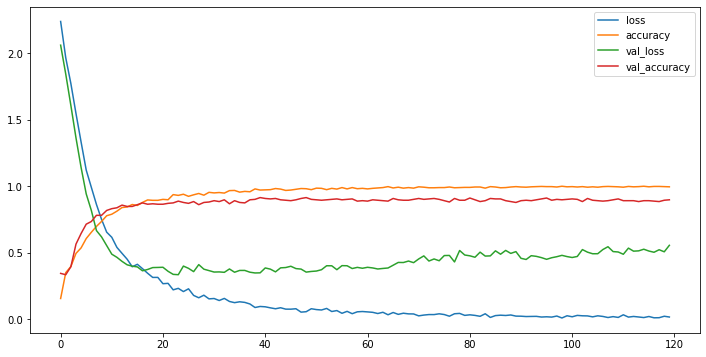

In [196]:
print('Validation Accuracy', max(history.history["val_accuracy"]))

pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show

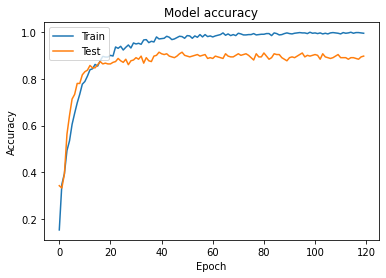

In [182]:
#Plot showing the model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


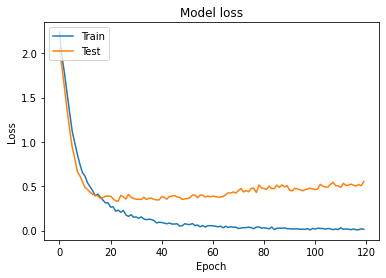

In [183]:
#Plot showing the Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


## Testing the model

---

Selecting samples to test the accuracy of the model's performance

In [184]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]


In [185]:
X_to_predict.shape

(26,)

In [186]:
print("Real Genre: ", y_to_predict)

Real Genre:  0


In [187]:
X_to_predict = X_to_predict[np.newaxis, ...]

In [188]:
# predictions
predictions = model.predict(X_to_predict)
# np.argmax(predictions[0])

In [189]:
# get index with max value
predicted_index = np.argmax(predictions, axis=1)

print("Predicted Genre:", int(predicted_index))

Predicted Genre: 0


In [190]:
# pick a sample to predict from the test set
X_to_predict = X_test[190]
y_to_predict = y_test[190]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

predictions = model.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(predictions, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 9
Predicted Genre: 9


In [191]:
len(X_test)

300

NOW WE TEST THE MODEL USING RANDOM SAMPLES

In [192]:
#Names of the genres and the labels they had been assigned
genre_dict = {0:"blues",1:"classical",2:"country",3:"disco",4:"hiphop",5:"jazz",6:"metal",7:"pop",8:"reggae",9:"rock"}

In [194]:
for n in range(20):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  predictions = model.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(predictions, axis=1)

  print("Predicted Genre:", int(predicted_index))
  print("Predicted Genre:", genre_dict[int(predicted_index)])


Real Genre: 6
Predicted Genre: 6
Predicted Genre: metal

Real Genre: 6
Predicted Genre: 6
Predicted Genre: metal

Real Genre: 4
Predicted Genre: 4
Predicted Genre: hiphop

Real Genre: 0
Predicted Genre: 0
Predicted Genre: blues

Real Genre: 1
Predicted Genre: 1
Predicted Genre: classical

Real Genre: 9
Predicted Genre: 9
Predicted Genre: rock

Real Genre: 0
Predicted Genre: 0
Predicted Genre: blues

Real Genre: 3
Predicted Genre: 3
Predicted Genre: disco

Real Genre: 2
Predicted Genre: 0
Predicted Genre: blues

Real Genre: 2
Predicted Genre: 2
Predicted Genre: country

Real Genre: 5
Predicted Genre: 5
Predicted Genre: jazz

Real Genre: 0
Predicted Genre: 0
Predicted Genre: blues

Real Genre: 9
Predicted Genre: 9
Predicted Genre: rock

Real Genre: 3
Predicted Genre: 3
Predicted Genre: disco

Real Genre: 6
Predicted Genre: 6
Predicted Genre: metal

Real Genre: 2
Predicted Genre: 2
Predicted Genre: country

Real Genre: 5
Predicted Genre: 5
Predicted Genre: jazz

Real Genre: 0
Predicted G

From the ouput displayed above, it is clear that most of the classifications are accurate, given that the model is performing at a high accuracy



---



---


